<a href="https://colab.research.google.com/github/fabriziobasso/Colab_backup/blob/main/File_08_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Time Series Forecasting for Retail Sales with MLP, ARIMA, KAN, and Chronos

references:

[github](https://github.com/ageron/handson-ml3/blob/main/15_processing_sequences_using_rnns_and_cnns.ipynb)


[article](https://medium.com/@kylejones_47003/time-series-forecasting-for-retail-sales-with-mlp-arima-kan-and-chronos-258abbbf4779)

[New Feature Colab](https://developers.googleblog.com/en/data-science-agent-in-colab-with-gemini/)

In [ ]:
# Necessry to run LGBMRegressor
!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd

In [ ]:
%%capture
#!pip install -qq pytorch_tabnet
!pip install optuna
!pip install catboost
#!pip install optuna-integration-pytorch-tabnet

!pip install tensorflow --upgrade
!pip install keras --upgrade

!pip install --upgrade category-encoders
!pip install optuna-integration
!pip install colorama
#!pip install pyfiglet
!pip install keras-tuner --upgrade
!pip install keras-nlp
!pip install BorutaShap
!pip install --upgrade scikit-learn
!pip install scikit-lego
!pip install skops
!pip install pykan
!pip install chronos-forecasting

#from pytorch_tabnet.tab_model import TabNetRegressor

In [ ]:
import pandas as pd
import numpy as np

from termcolor import colored
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import os
from joblib import dump, load
import pandas as pd
import numpy as np
from scipy.stats import iqr, skew, kurtosis, mode
import matplotlib.pyplot as plt
import joblib
%matplotlib inline
import seaborn as sns
sns.set_style("dark", {"grid.color": ".1", "grid.linestyle": ":", "axes.facecolor": ".9"})

from warnings import filterwarnings
from termcolor import colored
from warnings import filterwarnings; filterwarnings(action = 'ignore');
from tqdm.notebook import tqdm

from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin, clone
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, log_loss, \
                            mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, \
                            make_scorer,root_mean_squared_error

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer, FunctionTransformer, \
                                  OrdinalEncoder, OneHotEncoder

from sklearn.cluster import KMeans
from sklearn.base import clone

from category_encoders import TargetEncoder, CatBoostEncoder, LeaveOneOutEncoder, OrdinalEncoder, CountEncoder
from sklearn.impute import SimpleImputer

from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold, RepeatedStratifiedKFold, \
                                    cross_val_score, RepeatedKFold
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import k_means
from sklearn.feature_selection import RFECV, SequentialFeatureSelector, mutual_info_classif, mutual_info_regression
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import VotingClassifier, StackingClassifier, VotingRegressor, StackingRegressor, \
                             RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier, ExtraTreesRegressor, \
                             HistGradientBoostingClassifier, HistGradientBoostingRegressor \

from lightgbm import LGBMClassifier, LGBMRegressor, early_stopping, log_evaluation
import lightgbm as lgb

from xgboost import XGBClassifier, XGBRegressor, DMatrix
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
import optuna
from optuna.samplers import TPESampler

import matplotlib as mpl


import tensorflow as tf
import keras
from keras import ops
from keras import layers

from keras.layers import Input, LSTM, Dense, Lambda, RepeatVector, Reshape, GRU
from keras.models import Model
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError

from keras.utils import FeatureSpace, plot_model

# Import libraries for Hypertuning
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch, GridSearch, BayesianOptimization

In [ ]:
sns.set({"axes.facecolor"       : "#ffffff",
         "figure.facecolor"     : "#ffffff",
         "axes.edgecolor"       : "#000000",
         "grid.color"           : "#ffffff",
         "font.family"          : ['Cambria'],
         "axes.labelcolor"      : "#000000",
         "xtick.color"          : "#000000",
         "ytick.color"          : "#000000",
         "grid.linewidth"       : 0.5,
         'grid.alpha'           :0.5,
         "grid.linestyle"       : "--",
         "axes.titlecolor"      : 'black',
         'axes.titlesize'       : 12,
#         'axes.labelweight'     : "bold",
         'legend.fontsize'      : 7.0,
         'legend.title_fontsize': 7.0,
         'font.size'            : 7.5,
         'xtick.labelsize'      : 7.5,
         'ytick.labelsize'      : 7.5,
        });

sns.set_style("whitegrid",{"grid.linestyle":"--", 'grid.linewidth':0.2, 'grid.alpha':0.5})
# Set Style
mpl.rcParams['figure.dpi'] = 120;

# import font colors
from colorama import Fore, Style, init

# Making sklearn pipeline outputs as dataframe:-
pd.set_option('display.max_columns', 100);
pd.set_option('display.max_rows', 50);

sns.despine(left=True, bottom=True, top=False, right=False)

mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True

init(autoreset=True)

<Figure size 768x576 with 0 Axes>

**SPECIFIC LIBRARIES USED IN THE NOTEBOOK**

In [ ]:
import torch
import torch.nn as nn
import datetime
import random
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas_datareader import data as web
from sklearn.metrics import mean_squared_error, mean_absolute_error
from kan import KAN
from chronos import ChronosPipeline
import time

In [ ]:
# Connect to Colab:#
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
print("Keras backend:", keras.backend.backend())

Keras backend: tensorflow


Retail forecasting is high-stakes. Misses mean stockouts, markdowns, or investor panic. ARIMA is the legacy tool: fast, interpretable, consistent. Newer models like LSTMs and KANs claim to capture nonlinearity. Transformers promise everything.

We tested all of them using U.S. retail sales and updated the results through April 2025. The outcomes reflect real-world constraints: fixed forecast window, same input features, same evaluation horizon.

We pulled seasonally adjusted U.S. Retail and Food Services Sales from the FRED API:

In [ ]:
import pandas_datareader.data as web
import datetime

start = datetime.datetime(1990, 1, 1)
end = datetime.datetime(2025, 5, 1)
series = web.DataReader("RSAFS", "fred", start, end).dropna()["RSAFS"]
series.index.freq = "MS"

In [ ]:
mean_val, std_val = series.mean(), series.std()
norm_series = (series - mean_val) / std_val

Data is in millions of U.S. dollars. We normalize it for neural networks but leave it raw for ARIMA. Our prediction window is 12 months. All models start their forecast at the same point: April 2024.

We use a lag window of 24 months. That’s long enough to capture seasonal trends, short enough to avoid structural breaks.

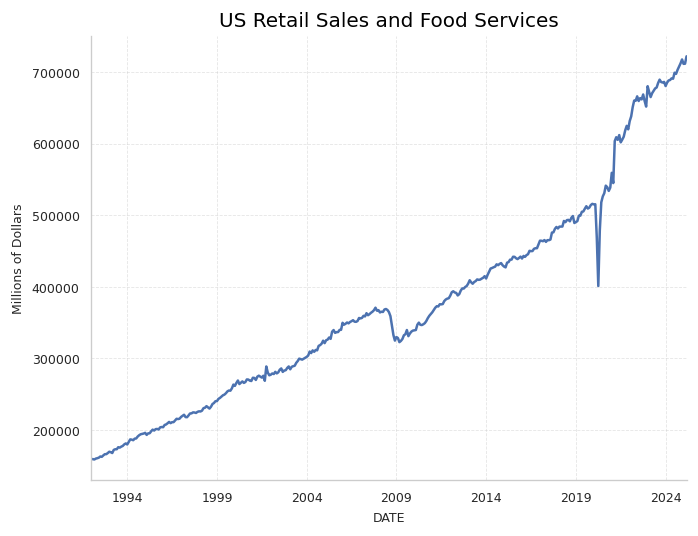

In [ ]:
series.plot()
plt.title("US Retail Sales and Food Services")
plt.ylabel("Millions of Dollars")
plt.show()

In [ ]:
# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
keras.utils.set_random_seed(seed)
tf.random.set_seed(seed)

# Unified config
prediction_length = 12
window = 24

In [ ]:
def make_lagged(series, window):
    X, y = [], []
    for i in range(len(series) - window):
        X.append(series.iloc[i:i + window].values)
        y.append(series.iloc[i + window])
    return np.array(X), np.array(y)

In [ ]:
# Split
split = series.index[-(window + prediction_length)]
train_raw, test_raw = series[series.index <= split], series[series.index > split]
train_norm, test_norm = norm_series[norm_series.index <= split], norm_series[norm_series.index > split]

In [ ]:
train_raw.shape, test_raw.shape

((364,), (35,))

In [ ]:
X_train, y_train = make_lagged(train_norm, window)
X_test, y_test = make_lagged(test_norm, window)

In [ ]:
y_test#.shape

array([2.1654686 , 2.16177774, 2.21919403, 2.20844212, 2.24635351,
       2.27728571, 2.30820427, 2.34584277, 2.30353783, 2.30503191,
       2.37560836])

In [ ]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)

In [ ]:
X_train_k = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
y_train_k = y_train.reshape(y_train.shape[0], 1)
X_test_k = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
y_test
X_train.shape,y_train.shape,X_test_k.shape

((340, 24), (340,), (11, 24, 1))

## 1.0 Arima Model:

In [ ]:
import statsmodels.api as sm

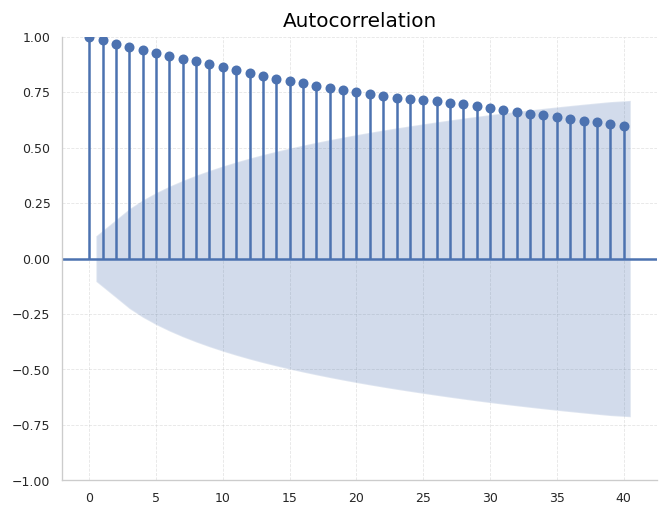

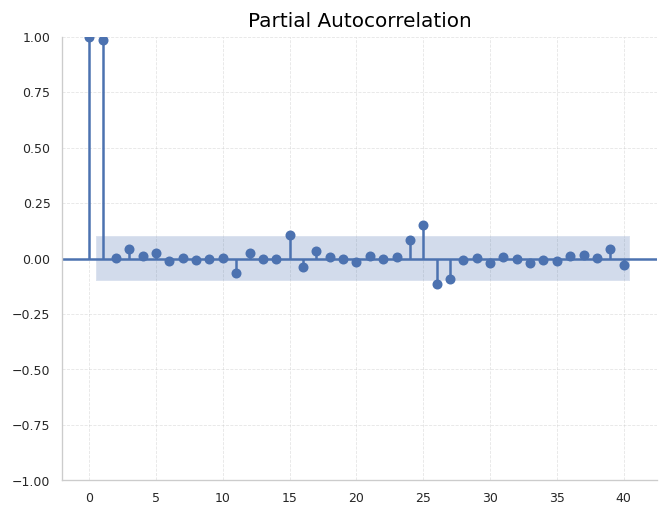

In [ ]:
sm.graphics.tsa.plot_acf(train_raw.values.squeeze(), lags=40)
sm.graphics.tsa.plot_pacf(train_raw.values.squeeze(), lags=40, method="ywm")
plt.show()

In [ ]:
train_raw.reset_index()

,DATE,RSAFS
0,1992-01-01,159177
1,1992-02-01,159189
2,1992-03-01,158647
3,1992-04-01,159921
4,1992-05-01,160471
...,...,...
359,2021-12-01,619938
360,2022-01-01,631509
361,2022-02-01,638101
362,2022-03-01,651027


In [ ]:
len(test_raw)

35

In [ ]:
# ARIMA
start_arima = time.time()
arima = SARIMAX(endog=train_raw, dates=train_raw.index, order=(2, 1, 0), seasonal_order=(1, 1, 1, 12)).fit()
arima = ARIMA(train_raw, order=(2, 1, 0),seasonal_order=(1, 1, 1, 12)).fit()
pred_arima = arima.forecast(steps=len(test_raw))
pred_arima.index = test_raw.index
arima_time = time.time() - start_arima

In [ ]:
print(arima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              RSAFS   No. Observations:                  364
Model:             ARIMA(2, 1, 0)x(1, 1, [1], 12)   Log Likelihood               -3714.219
Date:                            Wed, 30 Apr 2025   AIC                           7438.439
Time:                                    16:42:15   BIC                           7457.743
Sample:                                01-01-1992   HQIC                          7446.122
                                     - 04-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0297      0.022      1.345      0.179      -0.014       0.073
ar.L2         -0.1631      0.031   

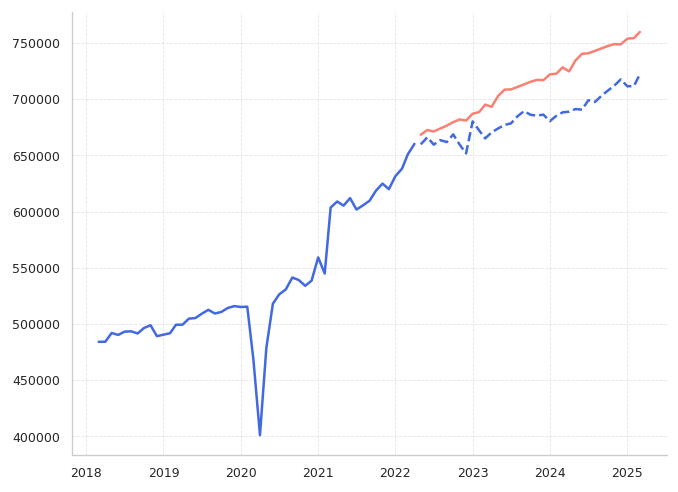

In [ ]:
plt.plot(train_raw[-50:], color="royalblue")
plt.plot(test_raw, color="royalblue", linestyle="dashed")
plt.plot(pred_arima, color="salmon")

plt.show()

**Store Results**

In [ ]:
def store_results(error_df, target, predic, model_name="insert_name"):
  df = error_df.copy()
  t = target.copy()
  p = predic.copy()

  df[:][model_name]=0

  df.loc[model_name,"RMSE"] = np.round(root_mean_squared_error(t,p),2)
  df.loc[model_name,"MAE"] = np.round(mean_absolute_error(t,p)  ,2)
  df.loc[model_name,"MAPE"] = np.round(mean_absolute_percentage_error(t,p),4)

  return df

In [ ]:
print(test_raw.shape, pred_arima.shape)
root_mean_squared_error(test_raw[:12],pred_arima[:12])

df_error = pd.DataFrame(columns=["RMSE","MAE","MAPE"])
df_results = store_results(df_error, test_raw, pred_arima, model_name="ARIMA")
df_results

(35,) (35,)


,RMSE,MAE,MAPE
ARIMA,31839.35,29438.18,0.0427


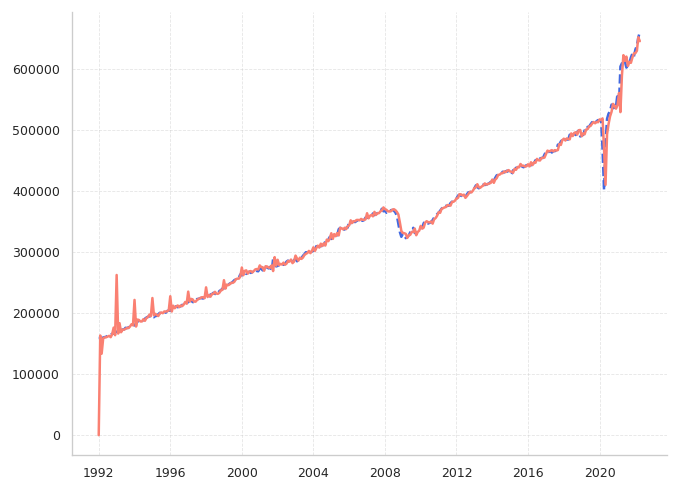

In [ ]:
pred_arima_is = arima.predict()

plt.plot(train_raw, color="royalblue", linestyle="dashed")
plt.plot(pred_arima_is, color="salmon")

## 2.0 Neural Networks:

In [ ]:
tf.random.set_seed(42)
ahead=35

def split_inputs_and_targets(series, ahead=35, target_col=None):
    return tf.expand_dims(series[:, :-ahead],-1), series[:, -ahead:]

In [ ]:
sampler = keras.utils.timeseries_dataset_from_array(
                                                      norm_series,
                                                      sequence_length=36+ahead,
                                                      targets=None,
                                                      sequence_stride=1,
                                                      sampling_rate=1,
                                                      batch_size=12,
                                                      shuffle=False,
                                                      seed=42,
                                                      start_index=None,
                                                      end_index=None
                                                  ).map(split_inputs_and_targets)

In [ ]:
norm_series_k = norm_series.values
norm_series_k.shape

(399,)

In [ ]:
for a, b in sampler.take(1):
  print(a.shape, b.shape)

(12, 36, 1) (12, 35)


In [ ]:
norm_series_train_v0 = norm_series.iloc[:-ahead]
norm_series_test = norm_series.iloc[-(36+ahead):]

In [ ]:
train_sampler = keras.utils.timeseries_dataset_from_array(
                                                      norm_series_train_v0,
                                                      sequence_length=36+ahead,
                                                      targets=None,
                                                      sequence_stride=1,
                                                      sampling_rate=1,
                                                      batch_size=12,
                                                      shuffle=False,
                                                      seed=42,
                                                      start_index=None,
                                                      end_index=None
                                                  ).map(split_inputs_and_targets)

test_sampler = keras.utils.timeseries_dataset_from_array(
                                                      norm_series_test,
                                                      sequence_length=36+ahead,
                                                      targets=None,
                                                      sequence_stride=1,
                                                      sampling_rate=1,
                                                      batch_size=12,
                                                      shuffle=False,
                                                      seed=42,
                                                      start_index=None,
                                                      end_index=None
                                                  ).map(split_inputs_and_targets)

In [ ]:
for a, b in test_sampler.take(1):
  print(a.shape, b.shape)

(1, 36, 1) (1, 35)


**CREATE NUMPY VERSION FOR PYTORCH**

In [ ]:
train_sampler_ = keras.utils.timeseries_dataset_from_array(
                                                      norm_series_train_v0,
                                                      sequence_length=36+ahead,
                                                      targets=None,
                                                      sequence_stride=1,
                                                      sampling_rate=1,
                                                      batch_size=1024,
                                                      shuffle=False,
                                                      seed=42,
                                                      start_index=None,
                                                      end_index=None
                                                  ).map(split_inputs_and_targets)

test_sampler_ = keras.utils.timeseries_dataset_from_array(
                                                      norm_series_test,
                                                      sequence_length=36+ahead,
                                                      targets=None,
                                                      sequence_stride=1,
                                                      sampling_rate=1,
                                                      batch_size=1024,
                                                      shuffle=False,
                                                      seed=42,
                                                      start_index=None,
                                                      end_index=None
                                                  ).map(split_inputs_and_targets)

In [ ]:
for xtrain_numpy, ytrain_numpy in train_sampler_.take(1):
  print(xtrain_numpy.shape, ytrain_numpy.shape)

xtrain_numpy = xtrain_numpy.numpy()
ytrain_numpy = ytrain_numpy.numpy()

for xtest_numpy, ytest_numpy in test_sampler_.take(1):
  print(xtest_numpy.shape, ytest_numpy.shape)

xtest_numpy = xtest_numpy.numpy()
ytest_numpy = ytest_numpy.numpy()

(294, 36, 1) (294, 35)
(1, 36, 1) (1, 35)


### 2.1 LSTM

In [ ]:
from keras.models import Sequential

In [ ]:
class lstm_model:
  def __init__(self, input_shape, output_shape):
    self.input_shape = input_shape
    self.output_shape = output_shape
    self.model = self.build_model()

  def build_model(self,units=64):
    model = Sequential()
    model.add(GRU(units, activation="tanh", input_shape=self.input_shape, kernel_regularizer=keras.regularizers.l2(0.001), dropout=0.2, return_sequences=False))
    #model.add(GRU(int(units/2), activation="relu", input_shape=self.input_shape, kernel_regularizer=keras.regularizers.l2(0.001), dropout=0.2, return_sequences=False))
    model.add(layers.BatchNormalization())
    model.add(Dense(64,activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.25))
    model.add(Dense(self.output_shape[0]))
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
input_shape = (36, 1)
output_shape = (35, 1)
lstm_mod = lstm_model(input_shape, output_shape)
model_v0 = lstm_mod.build_model(64)

In [ ]:
model_v0.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_23 (GRU)                    │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 35)             │         2,275 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,811 (77.39 KB)

 Trainable params: 19,555 (76.39 KB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
model_v0.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError(name="mean_squared_error"),
              metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])

**FIT THE MODEL:**

In [ ]:
xtrain_numpy.shape

(294, 36, 1)

In [ ]:
# Fit the model
model_v0.fit(xtrain_numpy,ytrain_numpy,
              validation_split=0.2,
              epochs=120,
              batch_size=16,
              callbacks=[keras.callbacks.ReduceLROnPlateau(patience=7, min_lr=0.00001, factor=0.5),
                         keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True, monitor="val_RMSE",
                                                        start_from_epoch=3, mode="min")])

Epoch 1/120
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - RMSE: 0.2485 - loss: 0.0679 - val_RMSE: 0.2299 - val_loss: 0.0588 - learning_rate: 1.0000e-05
Epoch 2/120
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - RMSE: 0.2662 - loss: 0.0771 - val_RMSE: 0.2106 - val_loss: 0.0503 - learning_rate: 1.0000e-05
Epoch 3/120
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - RMSE: 0.2743 - loss: 0.0814 - val_RMSE: 0.1914 - val_loss: 0.0425 - learning_rate: 1.0000e-05
Epoch 4/120
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - RMSE: 0.2660 - loss: 0.0771 - val_RMSE: 0.1797 - val_loss: 0.0382 - learning_rate: 1.0000e-05
Epoch 5/120
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - RMSE: 0.2708 - loss: 0.0802 - val_RMSE: 0.1717 - val_loss: 0.0354 - learning_rate: 1.0000e-05
Epoch 6/120
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - RMSE: 0.2626 - loss: 0.0761 - val_RMSE: 0.1678 - val_loss: 0.0341 - learning_rate: 1.0000e-05
Epoch 7/120
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - RMSE: 0.2672 - loss: 0.0779 - val_RMSE: 0.1665 - val_loss:

In [ ]:
# Fit the model
model_v0.fit(xtrain_numpy[:280,],ytrain_numpy[:280],
              validation_data=[xtrain_numpy[280:,],ytrain_numpy[280:]],
              epochs=211,
              batch_size=16,
              callbacks=[keras.callbacks.ReduceLROnPlateau(patience=5, min_lr=0.00001, factor=0.5),
                         keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True, monitor="val_RMSE",
                                                        start_from_epoch=3, mode="min")])

Epoch 1/211
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - RMSE: 0.2966 - loss: 0.0941 - val_RMSE: 0.2743 - val_loss: 0.0812 - learning_rate: 1.0000e-05
Epoch 2/211
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - RMSE: 0.3050 - loss: 0.0992 - val_RMSE: 0.2971 - val_loss: 0.0942 - learning_rate: 1.0000e-05
Epoch 3/211
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - RMSE: 0.3141 - loss: 0.1049 - val_RMSE: 0.3188 - val_loss: 0.1076 - learning_rate: 1.0000e-05
Epoch 4/211
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - RMSE: 0.3061 - loss: 0.0997 - val_RMSE: 0.3452 - val_loss: 0.1251 - learning_rate: 1.0000e-05
Epoch 5/211
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - RMSE: 0.3321 - loss: 0.1169 - val_RMSE: 0.3618 - val_loss: 0.1368 - learning_rate: 1.0000e-05
Epoch 6/211
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - RMSE: 0.3209 - loss: 0.1100 - val_RMSE: 0.3768 - val_loss: 0.1479 - learning_rate: 1.0000e-05
Epoch 7/211
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - RMSE: 0.3014 - loss: 0.0976 - val_RMSE: 0.3872 - val_loss:

In [ ]:
path = "/content/drive/MyDrive/Medium"
#model_v0.save(path+'/location.keras')
#model_v0 = keras.models.load_model(path+'/location.keras')

model_v0.save(path+'/location_v0.keras')
model_v0 = keras.models.load_model(path+'/location_v0.keras')

In [ ]:
lstm_pred = model_v0.predict(xtest_numpy)

lstm_pred = (lstm_pred*std_val) + mean_val

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


In [ ]:
lstm_pred

array([[631736.45954731, 633751.41267231, 640388.44392231,
        635411.08454731, 651783.19392231, 649525.16267231,
        657254.56892231, 655275.81892231, 656482.75642231,
        655415.72517231, 666571.16267231, 672668.56892231,
        676508.35017231, 680859.41267231, 675323.28767231,
        679496.19392231, 692323.28767231, 695126.28767231,
        692256.66267231, 697370.13142231, 699360.75642231,
        707691.60017231, 706990.31892231, 708222.13142231,
        698223.19392231, 713043.10017231, 709782.97517231,
        714752.16267231, 709849.88142231, 714159.75642231,
        708301.38142231, 719320.31892231, 714287.94392231,
        715382.41267231, 722712.85017231]])

In [ ]:
lstm_test_stor = (xtest_numpy*std_val) + mean_val

lstm_test_stor

array([[[504741.],
        [505251.],
        [509091.],
        [512561.],
        [509282.],
        [510648.],
        [514215.],
        [515866.],
        [515119.],
        [515330.],
        [468324.],
        [401028.],
        [478449.],
        [518038.],
        [526304.],
        [530735.],
        [541302.],
        [539114.],
        [533941.],
        [538548.],
        [559230.],
        [544891.],
        [603581.],
        [608961.],
        [605282.],
        [611950.],
        [601817.],
        [605533.],
        [609671.],
        [618573.],
        [624874.],
        [619938.],
        [631509.],
        [638101.],
        [651027.],
        [660194.]]])

In [ ]:
pred_lstm = pd.Series(lstm_pred.flatten(), index=test_raw.index)

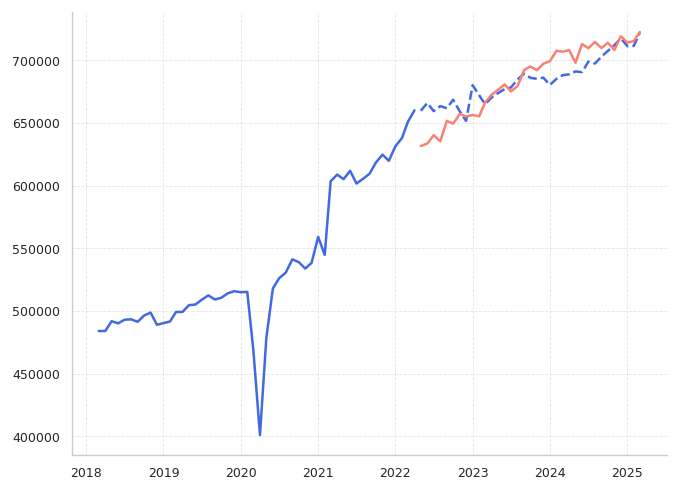

In [ ]:
plt.plot(train_raw[-50:], color="royalblue")
plt.plot(test_raw, color="royalblue", linestyle="dashed")
plt.plot(pred_lstm, color="salmon")

plt.show()

In [ ]:
df_results = store_results(df_results, test_raw, pred_lstm, model_name="LSTM")
df_results

,RMSE,MAE,MAPE
ARIMA,31839.35,29438.18,0.0427
LSTM,14466.86,11263.21,0.0166


In [ ]:
# Fit the model
sample_=100
lstm_pred_exp0 = model_v0.predict(xtrain_numpy[sample_,].reshape(1,36,1))

lstm_pred_exp0 = (lstm_pred_exp0*std_val) + mean_val

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


In [ ]:
lstm_pred_exp0.shape,xtest_numpy.shape

((1, 35), (1, 36, 1))

In [ ]:
ytrain_numpy_exp0 = (ytrain_numpy[sample_]*std_val) + mean_val
ytrain_numpy_exp0.shape

(35,)

In [ ]:
ytrain_numpy_exp0.shape,lstm_pred_exp0.shape

((35,), (1, 35))

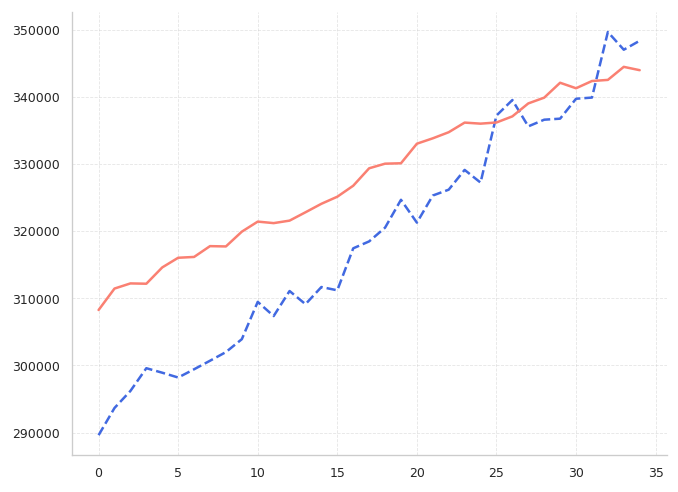

In [ ]:
plt.plot(ytrain_numpy_exp0, color="royalblue", linestyle="dashed")
plt.plot(np.squeeze(lstm_pred_exp0), color="salmon")

plt.show()

### 2.2 KAN

In [ ]:
xtrain_numpy.shape,ytrain_numpy.shape,xtest_numpy.shape

((294, 36, 1), (294, 35), (1, 36, 1))

In [ ]:
X_train_t = torch.tensor(xtrain_numpy.squeeze(), dtype=torch.float32)
y_train_t = torch.tensor(ytrain_numpy, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(xtest_numpy, dtype=torch.float32)



In [ ]:
loss_fn = nn.MSELoss()

# KAN
kan = KAN([window, 32, 1], grid=3, k=2)
opt_kan = torch.optim.Adam(kan.parameters(), lr=0.01)

start_kan = time.time()
for _ in range(200):
    kan.train(); opt_kan.zero_grad()
    loss = loss_fn(kan(X_train_t), y_train_t); loss.backward(); opt_kan.step()
kan_time = time.time() - start_kan

kan.eval(); pred_kan = kan(X_test_t).squeeze().detach().numpy()

checkpoint directory created: ./model
saving model version 0.0


In [ ]:
X_train_t.shape, y_train_t.shape

(torch.Size([340, 24]), torch.Size([340, 1]))

In [ ]:
data.X.shape, data.y.shape, data.X_test.shape

In [ ]:
print(data.cat_features)

In [ ]:
data.X.info(),data.X_test.info(),

# 3. Data Preprocessing
Here we define a preprocessing class to handle missing values and perform some feature engineering.

In [ ]:
class Preprocessing:
    def __init__(self, data: Data):
        self.data = data

    def feature_preparation(self):
        ''' User-define feature engineering and preprocessing'''
        print('⇒ Train-Test-Original shapes before preprocessing:',
              self.data.train.shape, self.data.test.shape, self.data.original.shape)

        df = pd.concat([self.data.train, self.data.test, self.data.original], axis=0)
        ## -- Operations
        # Convert categoricals and handle missing
        df = self.convert_categorical(df)
        df = self.handle_nan(df)

        # Retrieve train, test and original
        self.data.train    = df[:len(self.data.train)].reset_index(drop=True)
        self.data.test     = df[len(self.data.train):len(self.data.train)+\
                                len(self.data.test)].reset_index(drop=True).drop(columns=data.target)
        self.data.original = df[len(self.data.train)+len(self.data.test):].reset_index(drop=True)
        print('⇒ Train-Test-Original shapes after preprocessing:', self.data.train.shape, self.data.test.shape, self.data.original.shape)
        print('⇒ Preprocessing finished')

    @staticmethod
    def convert_categorical(df):
        '''For converting data to categoricals'''
        for c in df.select_dtypes(include=['object', 'category', 'bool', 'int']).columns:
            df[c] = df[c].astype(str).fillna('missing').astype('int')
        return df

    @staticmethod
    def handle_nan(df):
        for c in df.select_dtypes(exclude=['object', 'category', 'bool', 'int']).columns:
            df[c] = df[c].fillna(df[c].median())

        for c in df.select_dtypes(include=['object', 'category', 'bool', 'int']).columns:
            df[c] = df[c].fillna(df[c].mode()[0])

        return df

    @staticmethod
    def calculate_fi():

        def sorted_fi(fi): # fi is a list of feature importances
            fi = list(zip(data.X.columns.to_list(), fi))
            return sorted(fi, key=lambda x: x[1], reverse=True)

        # Make a pipeline to transform X for those method which can't handle categorical and NaN natively
        pipe    = make_pipeline(SimpleImputer(strategy='most_frequent'), CountEncoder(), StandardScaler())
        X_FE    = pipe.fit_transform(data.X)

        FI_LGBM = sorted_fi(LGBMRegressor(verbose=-1, random_state=CFG.SEED).fit(data.X, data.y).feature_importances_)

        FI_CB   = sorted_fi(CatBoostRegressor(verbose=0, random_state=CFG.SEED, cat_features=data.cat_features).fit(data.X, data.y).get_feature_importance())

        FI_RF   = sorted_fi(RandomForestRegressor(n_estimators=100, random_state=CFG.SEED).fit(X_FE, data.y).feature_importances_)

        FI_MI   = sorted_fi(list(mutual_info_regression(X_FE, data.y)))

        FIS     = [FI_LGBM, FI_CB, FI_RF, FI_MI]
        titles  = ['LGBM FI', 'CB FI', 'RF FI', 'MI']

        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(25, 10))
        for i, FI in enumerate(FIS):
            # Convert the list of tuples to a DataFrame for easier plotting
            FI_df = pd.DataFrame(FI[:15], columns=['Feature', 'Importance'])
            sns.barplot(x='Importance', y='Feature', data=FI_df, ax=axes[i], palette='Blues_r')
            axes[i].set_title(titles[i])

        plt.tight_layout()
        plt.show()


data = Data()
pp   = Preprocessing(data)
pp.feature_preparation()
#pp.calculate_fi()

In [ ]:
data.cat_features,data.num_features

In [ ]:
data.X.info()

# 4. Modeling

### 4.0 Neural Network Model Functions:

In [ ]:
cat_features_card = []
for f in data.cat_features:
  cat_features_card.append(1 + data.X[f].astype("int").max())

cat_features_card

In [ ]:
from keras.saving import register_keras_serializable

#####################################################################################################################################################################################
def build_model_v0_mm(units=512,last_layer = 1, activation="relu",cat_features=data.cat_features,cat_features_card=cat_features_card):

    x_input_cats = layers.Input(shape=(len(cat_features),))
    embs = []
    for j in range(len(cat_features)):
        e = layers.Embedding(cat_features_card[j], int(np.ceil(np.sqrt(cat_features_card[j]))))
        x = e(x_input_cats[:,j])
        x = layers.Flatten()(x)
        embs.append(x)

    x_input_nums = layers.Input(shape=(len(data.num_features),))

    x = layers.Concatenate(axis=-1)(embs+[x_input_nums])
    x = layers.Dense(units, activation=activation)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(units, activation=activation)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(int(units/last_layer), activation=activation)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=[x_input_cats,x_input_nums], outputs=x)
    return model

#####################################################################################################################################################################################
def build_model_v0(units=512,last_layer = 1, activation="relu",cat_features=data.cat_features,cat_features_card=cat_features_card):

    x_input_cats = layers.Input(shape=(len(cat_features),))
    embs = []
    for j in range(len(cat_features)):
        e = layers.Embedding(cat_features_card[j], int(np.ceil(np.sqrt(cat_features_card[j]))))
        x = e(x_input_cats[:,j])
        x = layers.Flatten()(x)
        embs.append(x)

    x_input_nums = layers.Input(shape=(len(data.num_features),))

    x = layers.Concatenate(axis=-1)(embs+[x_input_nums])
    x = layers.Dense(units, activation=activation)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(units, activation=activation)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(int(units/last_layer), activation=activation)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(1, activation='linear')(x)

    model = keras.Model(inputs=[x_input_cats,x_input_nums], outputs=x)
    return model

#####################################################################################################################################################################################
def build_model_v1(units=512,last_layer = 1, activation="relu", cat_features=data.cat_features,cat_features_card=cat_features_card, dropout_rate=0.35, reg=0.001):

    x_input_cats = layers.Input(shape=(len(cat_features),))
    embs = []
    for j in range(len(cat_features)):
        e = layers.Embedding(cat_features_card[j], int(np.ceil(np.sqrt(cat_features_card[j]))))
        x = e(x_input_cats[:,j])
        x = layers.Flatten()(x)
        embs.append(x)

    x_input_nums = layers.Input(shape=(len(data.num_features),))

    x = layers.Concatenate(axis=-1)(embs+[x_input_nums])

    # Reshape for the Attention layer.  Crucial for keras.layers.Attention
    # The Attention layer expects 3D tensors. Even if your "sequence"
    # length is 1, you MUST add a dimension.

    reshaped_features = layers.Reshape((1, -1))(x)

    attention_output = layers.Attention()([reshaped_features, reshaped_features])  # Self-attention

    # Flatten the attention output:
    flattened_attention = layers.Flatten()(attention_output)

    # Concatenate with original features (optional but often helpful):
    x = layers.Concatenate(axis=-1)([x, flattened_attention])

    x = layers.Dense(units, activation=activation, kernel_regularizer=keras.regularizers.l2(reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Dense(units, activation=activation, kernel_regularizer=keras.regularizers.l2(reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Dense(units, activation=activation, kernel_regularizer=keras.regularizers.l2(reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Dense(1, activation='linear')(x)

    model = keras.Model(inputs=[x_input_cats,x_input_nums], outputs=x)
    return model

#####################################################################################################################################################################################
def build_model_v2(units=512, last_layer=1, activation="relu", cat_features=data.cat_features,cat_features_card=cat_features_card,
                   repeat_att=2, dropout_rate=0.2, num_transformer_heads=4, transformer_units=64, reg=0.0001): # Reduced transformer_units

    x_input_cats = layers.Input(shape=(len(cat_features),))
    embs = []
    transformer_outputs = [] # List to store transformer outputs for each categorical feature

    for j in range(len(cat_features)):
        e = layers.Embedding(cat_features_card[j], int(np.ceil(np.sqrt(cat_features_card[j]))))
        x = e(x_input_cats[:, j])
        x = layers.Flatten()(x)
        x = layers.Dropout(dropout_rate)(x)
        embs.append(x)

        # Reshape for Transformer (batch_size, 1, features) - Crucial!
        reshaped_embedding = layers.Reshape((1, -1))(x)

        # Transformer Layer for each categorical feature
        for q in list(range(repeat_att)):
          if q == 0:
            attention_output = reshaped_embedding

          attention_output_ = layers.MultiHeadAttention(num_heads=num_transformer_heads, key_dim=transformer_units,name=f"mh_{j}_{q}")(attention_output, attention_output)
          attention_output_ = layers.LayerNormalization(name=f"mh_ln1_{j}_{q}")(attention_output + attention_output_) #ResNet_1
          attention_output_ = layers.Dense(reshaped_embedding.shape[-1], activation=activation,name=f"mh_dense_{j}_{q}")(attention_output_)
          attention_output = layers.LayerNormalization(name=f"mh_ln2_{j}_{q}")(attention_output + attention_output_) #ResNet_1

        transformer_outputs.append(layers.Flatten()(attention_output)) # Store flattened transformer output

    x_input_nums = layers.Input(shape=(len(data.num_features),))

    # Reshape for the Attention layer.  Crucial for keras.layers.Attention
    # The Attention layer expects 3D tensors. Even if your "sequence"
    # length is 1, you MUST add a dimension.

    x_orig = layers.Concatenate(axis=-1)(embs+[x_input_nums])
    reshaped_features = layers.Reshape((1, -1))(x_orig)

    attention_output = layers.Attention()([reshaped_features, reshaped_features])  # Self-attention

    # Flatten the attention output:
    flattened_attention = layers.Flatten()(attention_output)

    # Concatenate with original features (optional but often helpful):
    x = layers.Concatenate(axis=-1)([x_orig, flattened_attention])

    # Concatenate Transformer outputs and numerical features
    all_features = layers.Concatenate(axis=-1)(transformer_outputs + [x])

    x = layers.Dense(units, activation=activation, kernel_regularizer=keras.regularizers.l2(reg))(all_features)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Dense(units, activation=activation, kernel_regularizer=keras.regularizers.l2(reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Dense(int(units/last_layer), activation=activation, kernel_regularizer=keras.regularizers.l2(reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    #x = layers.Concatenate(axis=-1)([x_orig, x])

    x = layers.Dense(1, activation='linear')(x)

    model = keras.Model(inputs=[x_input_cats,x_input_nums], outputs=x)
    return model

  ####################################################
@register_keras_serializable()
class exitesqueeze_layer(layers.Layer):
    def __init__(self, exite_units,dropout_rate,activation,reg,**kwargs):
        super().__init__(**kwargs)

        self.exite_units = exite_units
        self.activation=activation
        self.reg=reg
        self.dropout_rate=dropout_rate

        self.reshaped_0 = layers.Reshape((-1, 1))
        self.reshaped_1 = layers.Reshape((-1, ))

        self.exite = layers.Dense(self.exite_units, activation=self.activation)
        self.squeeze = layers.Dense(1, activation="linear",kernel_regularizer=keras.regularizers.l2(reg))
        self.lnorm_00 = layers.LayerNormalization()
        self.lnorm_01 = layers.LayerNormalization()
        self.drop = layers.Dropout(rate=self.dropout_rate)
        self.attention = layers.Attention()

    def call(self, inputs):
        x = self.reshaped_0(inputs)
        x = self.exite(x)
        att_out = self.attention([x,x])
        att_out = self.lnorm_00(att_out)
        x = layers.add([x, att_out])
        x = self.squeeze(x)
        x = self.reshaped_1(x)

        x = layers.multiply([x, inputs])

        x = self.lnorm_01(x)
        x = self.drop(x)

        return x

    # Remove build warnings
    def build(self):
        self.built = True

    # Required for serialization:
    def get_config(self):
        config = super().get_config()
        config.update({
            'exite_units': self.exite_units,
            'dropout_rate': self.dropout_rate, # Include necessary config items
            'activation': self.activation,
            'reg': self.reg
        })
        return config


def build_model_v3(units=512,exite_units=64, last_layer = 1, activation="relu", reg=0.001, dropout_rate=0.33):

    x_input_cats = layers.Input(shape=(len(data.cat_features),))
    embs = []
    for j in range(len(data.cat_features)):
        e = layers.Embedding(cat_features_card[j], int(np.ceil(np.sqrt(cat_features_card[j]))))
        x = e(x_input_cats[:,j])
        x = layers.Flatten()(x)
        embs.append(x)

    x_input_nums = layers.Input(shape=(len(data.num_features),))

    x_0 = layers.Concatenate(axis=-1, name="input_concat")(embs+[x_input_nums])

    es_0 = exitesqueeze_layer(exite_units=exite_units,
                              dropout_rate=dropout_rate,
                              activation=activation,
                              reg=reg)(x_0)

    x = layers.Concatenate(axis=-1, name="se_0_concat")([x_0,es_0])
    x = layers.BatchNormalization(name="se_0_bn")(x)

    es_1 = exitesqueeze_layer(exite_units=exite_units,
                              dropout_rate=dropout_rate,
                              activation=activation,
                              reg=reg)(x)

    x = layers.Concatenate(axis=-1, name="se_1_concat")([x,es_1])
    x = layers.BatchNormalization(name="se_1_bn")(x)

    es_2 = exitesqueeze_layer(exite_units=exite_units,
                              dropout_rate=dropout_rate,
                              activation=activation,
                              reg=reg)(x)

    x = layers.Concatenate(axis=-1, name="se_2_concat")([x,es_2])
    x = layers.BatchNormalization(name="se_2_bn")(x)

    x_0 = layers.Dense(units, name="dense_0", activation=activation, kernel_regularizer=keras.regularizers.l2(reg))(x_0)
    x_0 = layers.BatchNormalization(name="bn_0")(x_0)
    x_0 = layers.Dropout(dropout_rate,name="do_0")(x_0)

    x_0 = layers.Dense(int(units/last_layer), name="dense_1", activation=activation, kernel_regularizer=keras.regularizers.l2(reg))(x_0)
    x_0 = layers.BatchNormalization(name="bn_1")(x_0)
    x_0 = layers.Dropout(dropout_rate,name="do_1")(x_0)

    x = layers.Concatenate(axis=-1)([x_0,x])

    x = layers.Dense(1, activation='linear')(x)

    model = keras.Model(inputs=[x_input_cats,x_input_nums], outputs=x)
    return model

### 4.1 Stacking

In [ ]:
class TrainModels:
    def __init__(self, X, y, X_test, X_original, y_original, models):
        self.models     = models
        self.X          = X
        self.y          = y
        self.X_original = X_original
        self.y_original = y_original
        self.X_test     = X_test
        self._OOF_train = pd.DataFrame()
        self._OOF_test  = pd.DataFrame()
        self.categorical_features = X.select_dtypes(include=['category', 'bool', 'category','int']).columns.to_list()
        self.numerical_features = X.select_dtypes(include=['float']).columns.to_list()

    @staticmethod
    def convert_cat(df_):
        '''
        A function to convert dtypes to categorical if the catboost with all categorical
        features is called
        '''
        df = df_.copy()
        for c in df.columns.to_list():
            df[c] = df[c].astype(str).astype('category')
        return df


    def fit_model(self, name, model_, train_flag):
        oof_train = np.zeros(self.X.shape[0])
        oof_test  = np.zeros(self.X_test.shape[0])
        scores_train = []
        scores_val   = []

        CB_CAT_FLAG = True if 'CB_CAT' in name.upper() else False

        os.chdir('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/S5E2/layers_3_staked_models_opt')

        for fold, (train_idx, val_idx) in enumerate(CFG.CV.split(self.X, self.y)):
            x_train, y_train = self.X.iloc[train_idx], self.y.iloc[train_idx]
            x_val,   y_val   = self.X.iloc[val_idx],   self.y.iloc[val_idx]

            # Adds the original data to training set only
            if self.X_original is not None:
                x_train = pd.concat([x_train, self.X_original], axis=0)
                y_train = pd.concat([y_train, self.y_original], axis=0)

            x_train[self.categorical_features] = x_train[self.categorical_features].astype("int")
            x_train[self.numerical_features] = x_train[self.numerical_features].astype("float")

            x_val[self.categorical_features] = x_val[self.categorical_features].astype("int")
            x_val[self.numerical_features] = x_val[self.numerical_features].astype("float")

            self.X_test[self.categorical_features] = self.X_test[self.categorical_features].astype("int")
            self.X_test[self.numerical_features] = self.X_test[self.numerical_features].astype("float")

            #print(x_train.info())
            #print(x_val.info())
            #print(self.X_test.info())

            # -- Create a special block to convert all features to categorical
            if CB_CAT_FLAG:
                x_train = self.convert_cat(x_train)
                x_val   = self.convert_cat(x_val)
            if 'NN_' in name.upper():
              model = model_
            elif 'NNMM_' in name.upper():
              model = model_
            else:
              model = clone(model_)

#######################################################################################
            if 'NN_' in name.upper():

              model = model_

              X_train_cat = x_train[self.categorical_features].astype("int32")
              X_train_num = x_train[self.numerical_features].astype("float32")

              X_valid_cat = x_val[self.categorical_features].astype("int32")
              X_valid_num = x_val[self.numerical_features].astype("float32")

              X_test_cat = self.X_test[self.categorical_features].astype("int32")
              X_test_num = self.X_test[self.numerical_features].astype("float32")

              # Compile the model
              keras.utils.set_random_seed(42)

              optimizer = keras.optimizers.Adam(learning_rate=1e-3)
              model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError(name="mse"),
                            metrics=[keras.metrics.RootMeanSquaredError(name="rmse")])

              # Fit the model
              if train_flag==True:
                model.fit([X_train_cat,X_train_num], y_train,
                          validation_data=([X_valid_cat, X_valid_num], y_val),
                          epochs=111,
                          batch_size=2048,
                          callbacks=[keras.callbacks.ReduceLROnPlateau(patience=3, monitor="val_rmse", factor=0.5, min_lr=5e-5),
                                     keras.callbacks.EarlyStopping(patience=21, restore_best_weights=True, monitor="val_rmse",
                                                                    start_from_epoch=3, mode="min")])

                model.save(f'{name}_{CFG.VERSION}.keras') # Saving the model after training

              else:
                print("Load Model")
                model = keras.models.load_model(f'{name}_{CFG.VERSION}.keras') # Loading the saved model

#######################################################################################
            if 'NNMM_' in name.upper():

              model = model_

              X_train_cat = x_train[self.categorical_features].astype("int32")
              X_train_num = x_train[self.numerical_features].astype("float32")

              X_valid_cat = x_val[self.categorical_features].astype("int32")
              X_valid_num = x_val[self.numerical_features].astype("float32")

              X_test_cat = self.X_test[self.categorical_features].astype("int32")
              X_test_num = self.X_test[self.numerical_features].astype("float32")

              y_train_mm = (y_train-15)/135
              y_val_mm = (y_val-15)/135

              # Compile the model
              keras.utils.set_random_seed(42)

              optimizer = keras.optimizers.Adam(learning_rate=1e-3)
              model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError(name="mse"),
                            metrics=[keras.metrics.RootMeanSquaredError(name="rmse")])

              # Fit the model
              if train_flag==True:
                model.fit([X_train_cat,X_train_num], y_train_mm,
                          validation_data=([X_valid_cat, X_valid_num], y_val_mm),
                          epochs=111,
                          batch_size=2048,
                          callbacks=[keras.callbacks.ReduceLROnPlateau(patience=3, monitor="val_rmse", factor=0.5, min_lr=5e-5),
                                     keras.callbacks.EarlyStopping(patience=21, restore_best_weights=True, monitor="val_rmse",
                                                                    start_from_epoch=3, mode="min")])

                model.save(f'{name}_{CFG.VERSION}.keras') # Saving the model after training

              else:
                print("Load Model")
                model = keras.models.load_model(f'{name}_{CFG.VERSION}.keras') # Loading the saved model

#####################################################################################

            elif 'CB' in name.upper():
              if train_flag==True:
                model.fit(x_train,y_train,eval_set=[(x_val,y_val)], early_stopping_rounds=101)
                model.save_model(f"{name}_{fold}_{CFG.VERSION}.bin")
              else:
                print("Load Model")
                model = CatBoostRegressor()
                model.load_model(f"{name}_{fold}_{CFG.VERSION}.bin")

            elif 'LGBMR' in name.upper():
              early_stop = early_stopping(stopping_rounds=101)
              print(self.categorical_features)
              if train_flag==True:
                model.fit(x_train, y_train, eval_set=[(x_val, y_val)], callbacks=[early_stop],categorical_feature=self.categorical_features)
                model.booster_.save_model(f'{name}_{fold}_{CFG.VERSION}.txt')
              else:
                print("Load Model")
                model = lgb.Booster(model_file=f'{name}_{fold}_{CFG.VERSION}.txt')

            elif 'LGBMP' in name.upper():
              # Fit the model
              if train_flag==True:
                model.fit(x_train, y_train)
                dump(model, f'{name}_{fold}_{CFG.VERSION}.pkl')
              else:
                print("Load Model")
                model = load(f'{name}_{fold}_{CFG.VERSION}.pkl')

            elif 'XGBR' in name.upper():
              if train_flag==True:
                model.fit(x_train, y_train, eval_set=[(x_val, y_val)],verbose=250)
                model.save_model(f'{name}_{fold}_{CFG.VERSION}.json')
              else:
                print("Load Model")
                model = XGBRegressor()  # Create an instance of the model
                model.load_model(f'{name}_{fold}_{CFG.VERSION}.json')

            elif 'LGBM_2' in name.upper():
              model.fit(x_train, y_train, eval_set=[(x_val, y_val)])


            elif 'HGB_' in name.upper():
              if train_flag==True:
                model.fit(x_train, y_train)
                dump(model, f'{name}_{fold}_{CFG.VERSION}.pkl')
              else:
                print("Load Model")
                model = load(f'{name}_{fold}_{CFG.VERSION}.pkl')

            else:

              model.fit(x_train, y_train)


            #################### Predictions
            if 'NN_' in name.upper():
              y_pred_train = model.predict([X_train_cat,X_train_num], batch_size=2048).ravel()
              y_pred_val   = model.predict([X_valid_cat, X_valid_num], batch_size=2048).ravel()
              y_pred_test  = model.predict([X_test_cat, X_test_num], batch_size=1024).ravel()

            elif 'NNMM_' in name.upper():
              y_pred_train = model.predict([X_train_cat,X_train_num], batch_size=2048).ravel()
              y_pred_val   = model.predict([X_valid_cat, X_valid_num], batch_size=2048).ravel()
              y_pred_test  = model.predict([X_test_cat, X_test_num], batch_size=1024).ravel()

              y_pred_train = y_pred_train*135+15
              y_pred_val   = y_pred_val*135+15
              y_pred_test  = y_pred_test*135+15

            else:
              y_pred_train = model.predict(x_train).ravel()
              y_pred_val   = model.predict(x_val).ravel()
              y_pred_test  = model.predict(self.X_test if not CB_CAT_FLAG else self.convert_cat(self.X_test)).ravel()

            oof_train[val_idx] = y_pred_val
            oof_test   += y_pred_test/CFG.CV.get_n_splits()

            train_score = np.sqrt(mean_squared_error(y_train, y_pred_train))
            val_score   = np.sqrt(mean_squared_error(y_val, y_pred_val))

            print(f'Fold {fold+1} → Training set Score: {train_score:.5f} | Validation set Score: {val_score:.5f}')

            scores_train.append(train_score)
            scores_val.append(val_score)

        self._OOF_train[name] = oof_train
        self._OOF_test[name]  = oof_test

        os.chdir('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E2')

        print(colored(f'Overall → Training set Score: {np.mean(scores_train):.5f}±{np.std(scores_train):.7f} | Validation set Score: {np.mean(scores_val):.5f}±{np.std(scores_val):.7f}',
              color='green', attrs=['bold', 'dark']))

    def fit_models(self):
        for name, model in list(self.models.items()):
            print(colored(f'{" "*4} Fitting {name}', color='red', attrs=['dark', 'bold']))
            self.fit_model(name, model[0], model[1])
            print("")

    @property
    def OOF_train(self):
        return self._OOF_train
    @property
    def OOF_test(self):
        return self._OOF_test

    def save_predictions(self):
        self._OOF_train.to_csv('OOF_train_many_models.csv', index=False)
        self._OOF_test.to_csv('OOF_test_many_models.csv', index=False)

#### 4.1.1 First Level of Stacking
We define a bunch of tree-based methods with many different hyperparameters configurations to aggregate diversity.

In [ ]:
os.chdir('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E2')

In [ ]:
data.X.info(),data.test.info()
data.X.select_dtypes(include=['category', 'bool', 'category','int']).columns.to_list()

In [ ]:
lgbm_params_1 = {'num_leaves': 103, 'min_child_samples': 36, 'subsample': 0.9131771240297577, 'subsample_freq': 2, 'colsample_bytree': 0.6190291906152294, 'reg_alpha': 0.03976551748855951, 'reg_lambda': 0.2576052197300848}
lgbm_params_2 = {'max_depth': 5, 'learning_rate': 0.025, 'min_child_samples': 51, 'subsample': 0.90, 'subsample_freq': 1, 'colsample_bytree': 0.75, 'reg_alpha': 0.01, 'reg_lambda': 0.05}
#lgbm_params_5 = {'max_depth': 5, 'learning_rate': 0.055, 'n_estimators': 3000, 'num_leaves': 31}
#lgbm_params_6 = {'max_depth': 6, 'learning_rate': 0.01, 'n_estimators': 3000, 'num_leaves': 31}
#lgbm_params_6 = {'max_depth': 9, 'learning_rate': 0.02, 'n_estimators': 2000, 'num_leaves': 31, "subsample":0.85, "colsample_bytree":0.85,
#                 "reg_alpha":0.01, "reg_lambda":0.01, "boosting_type":"gbdt" }

cb_cat_params_1   = {'iterations': 3000,'learning_rate': 0.025,'depth': 9, 'l2_leaf_reg': 0.004177701145518355,
                     'bagging_temperature': 0.5, 'random_strength': 0.5,"bootstrap_type": "Bayesian",
                     'cat_features': data.cat_features,'task_type': 'GPU',
                     'random_seed':CFG.SEED,'verbose': 250,"od_type":'EBS',"od_wait":101,"use_best_model":True}

cb_cat_params_2   = {'iterations': 1000,'learning_rate': 0.025,'depth': 4, 'l2_leaf_reg': 0.001,
                     'bagging_temperature': 0.3, 'random_strength': 0.3,"bootstrap_type": "Bayesian",
                     'cat_features': data.cat_features,'task_type': 'GPU',
                     'random_seed':CFG.SEED,'verbose': 250,"od_type":'EBS',"od_wait":101,"use_best_model":True}

xgb_params_1 = {'n_estimators': 3000,'learning_rate': 0.025,'max_depth': 9,'min_child_weight': 9,'subsample': 0.95,'colsample_bytree': 0.75,
                'gamma': 0.5511841320880777,'reg_alpha': 0.006948944983035811,'reg_lambda': 0.0015661314558322087,
                'objective': "reg:squarederror",'eval_metric': "rmse", "early_stopping_rounds":101, 'device':'gpu', 'tree_method': 'gpu_hist',
                'random_state': CFG.SEED,'enable_categorical': True,"verbosity":0}

xgb_params_2 = {'n_estimators': 1500,'learning_rate': 0.025,'max_depth': 5,'min_child_weight': 9,'subsample': 0.90,'colsample_bytree': 0.80,
                'gamma': 0.10,'reg_alpha': 0.01,'reg_lambda': 0.01, 'objective': "reg:squarederror",'eval_metric': "rmse",
                "early_stopping_rounds":101, 'device':'gpu', 'tree_method': 'gpu_hist','random_state': CFG.SEED,'enable_categorical': True,"verbosity":0}

nn_params_v0 = {'units': 1024, 'last_layer': 2, 'activation': 'silu'}
nn_params_v1 = {'units': 512, 'last_layer': 1, 'activation': 'relu', 'reg': 0.0002133354415296107, 'dropout_rate': 0.47090232042440616}
nn_params_v2 = {'units': 256, 'last_layer': 1, 'activation': 'silu', 'reg': 0.0001, 'exite_units': 32, 'dropout_rate': 0.36}

models={
#        'LGBMR1_opt': [LGBMRegressor(learning_rate=0.02,boosting_type='gbdt',n_estimators=3000,objective="regression",eval_metric="rmse",device='gpu',verbose=-1,random_state= CFG.SEED,**lgbm_params_1),False],
#        'LGBMR2_opt': [LGBMRegressor(verbose=-1, random_state=CFG.SEED, boosting_type='gbdt', device='cpu',n_estimators=1000,objective="regression",eval_metric="rmse", **lgbm_params_2),False],
        #'LGBMR3': [LGBMRegressor(verbose=-1, random_state=CFG.SEED, data_sample_strategy='GOSS', device='gpu',n_estimators=211),False],
        #'LGBMP4': [make_pipeline(CatBoostEncoder(), LGBMRegressor(verbose=-1, random_state=CFG.SEED, **lgbm_params_4, device='gpu')),False],
        #'LGBMR5': [LGBMRegressor(verbose=-1, random_state=CFG.SEED, **lgbm_params_5, device='gpu'),False],
        #'LGBMR6': [LGBMRegressor(verbose=-1, random_state=CFG.SEED, **lgbm_params_6, device='gpu'),False],

#        'CB1_opt'   :[CatBoostRegressor(**cb_cat_params_1),False],
#        'CB2_opt'   : [CatBoostRegressor(**cb_cat_params_2),False],
    #    'CB3'   : [CatBoostRegressor(verbose=0, random_state=CFG.SEED, cat_features=data.cat_features, grow_policy='Lossguide', loss_function='RMSE', task_type='GPU', iterations=3000),False],
    #    'CB4'   : [CatBoostRegressor(verbose=0, random_state=CFG.SEED, cat_features=data.cat_features, **cb_cat_params_4, loss_function='RMSE', task_type='GPU', iterations=3000),False],
    #    'CB5'   : [CatBoostRegressor(verbose=0, random_state=CFG.SEED, cat_features=data.cat_features, iterations=3000, task_type='GPU'),False],
    #   'CB_CAT1': [CatBoostRegressor(verbose=0, random_state=CFG.SEED, cat_features=data.test.columns.to_list(), iterations=750, task_type='GPU'),True],
    #    'CB_CAT2': [CatBoostRegressor(verbose=0, random_state=CFG.SEED, cat_features=data.test.columns.to_list(), **cb_cat_params_4, loss_function='RMSE', task_type='GPU'),True],

#        'XGBR1_opt' : [XGBRegressor(**xgb_params_1),False],
#        'XGBR2_opt' : [XGBRegressor(**xgb_params_2),False],


#        'HGB_TE': [make_pipeline(TargetEncoder(), HistGradientBoostingRegressor(random_state=CFG.SEED, max_iter=5000,
#                                                                              learning_rate=0.035, max_depth=8,validation_fraction=0.15,
#                                                                              early_stopping=True, l2_regularization=0.03,
#                                                                             )),False],

      #  'HGB_CE': [make_pipeline(CountEncoder(), HistGradientBoostingRegressor(random_state=CFG.SEED, max_iter=5000,
      #                                                                          learning_rate=0.055, max_depth=5,
      #                                                                          early_stopping=True,  validation_fraction=0.15
      #                                                                        )),True],

#        "NN_v0" : [build_model_v0(**nn_params_v0),True],
#        "NN_v1" : [build_model_v1(**nn_params_v1),False],
#        "NN_v2" : [build_model_v3(**nn_params_v2),False],
         "NNMM_v0" : [build_model_v0_mm(**nn_params_v0),True],
        }

# TM = TrainModels(X=data.X, y=data.y, X_test=data.X_test, X_original=None, y_original=None, models=models)
# TM.fit_models()

In [ ]:
# TM.OOF_test.to_csv("Stacked_Models_step1_OOF_test.csv")
# TM.OOF_train.to_csv("Stacked_Models_step1_OOF_train.csv")

In [ ]:
OOF_train = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E2/Stacked_Models_step1_OOF_train.csv", index_col=0)
OOF_test = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E2/Stacked_Models_step1_OOF_test.csv", index_col=0)

In [ ]:
# OOF_train["NNMM_v0"] = TM.OOF_train["NNMM_v0"].values
# OOF_test["NNMM_v0"] = TM.OOF_test["NNMM_v0"].values
OOF_train["Target"] = data.y
OOF_train.head(5)

In [ ]:
# OOF_test.to_csv("Stacked_Models_step1_OOF_test.csv")
# OOF_train.to_csv("Stacked_Models_step1_OOF_train.csv")

In [ ]:
OOF_train.corr()

In [ ]:
x1 = OOF_train["Target"]
x2 = OOF_train["LGBMR1_opt"]

plt.scatter(x1,x2)
plt.show()

In [ ]:
OOF_train_clipped = OOF_train.clip(15,150).copy()
OOF_test_clipped = OOF_test.clip(15,150).copy()

OOF_train_clipped.describe()

In [ ]:
OOF_train_clipped.corr()

In [ ]:
OOF_train_clipped.describe()

#### 4.1.2 Second Level of Stacking
We take the out-of-folds predictions from the previous models and fed them into simple linear methods like Ridge and Lasso. The alpha parameters have been tuned manually (i.e., trial and error).

In [ ]:
models2 = {
          'Ridge2':[ Ridge(alpha=1),True],
          'Lasso2': [Lasso(alpha=0.0002),True],
          'LGBM_2' : [LGBMRegressor(max_depth=2, random_state=CFG.SEED, device='gpu'),True],
          }

TM2 = TrainModels(X=OOF_train_clipped.drop("Target",axis=1), y=data.y, X_test=OOF_test_clipped, X_original=None, y_original=None, models=models2)
TM2.fit_models()
data.submit(sub=TM2.OOF_test.mean(axis=1), desc='lasso_ridge_mean')

Validation set Score Unclipped: 38.35725±0.3112433

Validation set Score Clipped: 38.35690±0.3115080

In [ ]:
TM2_OOF_train = TM2.OOF_train.copy()
TM2_OOF_test = TM2.OOF_test.copy()

In [ ]:
submission = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E2/sample_submission.csv",index_col=0)
submission["Price"] = TM2.OOF_test.mean(axis=1).values
submission.to_csv("SUB_01_Second_Layer_clipped.csv")
second_layer_output = submission.copy()
display(submission.head())

#### 4.1.3 Third Level of Stacking
At this stage, the first level and second level out-of-fold predictions are incorporated into the original training data. This is then fed into another level of models to output the final stage of out-of-fold predictions which are finally averaged.

In [ ]:
data.cat_features,data.num_features

In [ ]:
train = pd.concat([data.X,      OOF_train.drop("Target",axis=1), TM2_OOF_train], axis=1)
test  = pd.concat([data.X_test, OOF_test,  TM2_OOF_test], axis=1)

models3 = {
          'LGBM_21' : [LGBMRegressor(verbose=-1, random_state=CFG.SEED, max_depth=4, device='gpu'),True],
          'CB_3'   : [CatBoostRegressor(verbose=0, random_state=CFG.SEED, cat_features=data.cat_features, task_type='GPU'),True],
          'Ridge_3': [make_pipeline(TargetEncoder(cols=data.cat_features), Ridge(alpha=5)),True],
          'Lasso_3': [make_pipeline(TargetEncoder(cols=data.cat_features), Lasso(alpha=0.001)),True],
          }

TM3  = TrainModels(X=train, y=data.y, X_test=test, X_original=None, y_original=None, models=models3)
TM3.fit_models()

TM3.save_predictions()

In [ ]:
data.submit(sub=TM3.OOF_test.mean(axis=1), desc='final_layer')

In [ ]:
TM3.OOF_test.mean(axis=1)

In [ ]:
TM3.save_predictions()

In [ ]:
TM3.OOF_test.mean(axis=1)

In [ ]:
submission = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E2/sample_submission.csv",index_col=0)
submission["Price"] = TM3.OOF_test.mean(axis=1).values
submission.to_csv("SUB_04_Final_Layer.csv")
final_layer_output = submission.copy()
display(submission.head())
submission["Price"] = TM2.OOF_test.mean(axis=1).values
submission.to_csv("SUB_04_Second_Layer.csv")
display(submission.head())
second_layer_output = submission.copy()

In [ ]:
OOF_train_clipped = OOF_train_clipped.clip(15,150)
OOF_test_clipped = OOF_test_clipped.clip(15,150)
OOF_test_clipped.describe()

In [ ]:
submission["Price"] = OOF_test_clipped["NN_v0"].values
submission.to_csv("SUB_03_NN0.csv")

In [ ]:
root_mean_squared_error(OOF_train_clipped["Target"],OOF_train_clipped["NN_v0"])

In [ ]:
TM3.OOF_train["Target"]=data.y.values

In [ ]:
OOF_train_level_3 = TM3.OOF_train
OOF_train_level_3

all_forecast_train = pd.concat([OOF_train.drop("Target",axis=1), TM2_OOF_train,OOF_train_level_3], axis=1)
all_forecast_test = pd.concat([OOF_test,  TM2_OOF_test,TM3.OOF_test], axis=1)

In [ ]:
all_forecast_test.corr()

In [ ]:
all_forecast_train.to_csv("all_forecast_train.csv")
all_forecast_test.to_csv("all_forecast_test.csv")

#### **4.6.4 NeuralNetwork v3**

In [ ]:
data.cat_features,data.num_features

In [ ]:
data.X.info()

In [ ]:
class exitesqueeze_layer(layers.Layer):
    def __init__(self, exite_units,dropout_rate,activation,reg):
        super().__init__()

        self.exite_units = exite_units
        self.activation=activation
        self.reg=reg

        self.reshaped_0 = layers.Reshape((-1, 1))
        self.reshaped_1 = layers.Reshape((-1, ))

        self.exite = layers.Dense(self.exite_units, activation=self.activation)
        self.squeeze = layers.Dense(1, activation="linear",kernel_regularizer=keras.regularizers.l2(reg))
        self.lnorm_00 = layers.LayerNormalization()
        self.lnorm_01 = layers.LayerNormalization()
        self.drop = layers.Dropout(rate=dropout_rate)
        self.attention = layers.Attention()

    def call(self, inputs):
        x = self.reshaped_0(inputs)
        x = self.exite(x)
        att_out = self.attention([x,x])
        att_out = self.lnorm_00(att_out)
        x = layers.add([x, att_out])
        x = self.squeeze(x)
        x = self.reshaped_1(x)

        x = layers.multiply([x, inputs])

        x = self.lnorm_01(x)
        x = self.drop(x)

        return x

    # Remove build warnings
    def build(self):
        self.built = True

In [ ]:
def build_model(units=512,exite_units=64, last_layer = 1, activation="relu", reg=0.001, dropout_rate=0.33):

    x_input_cats = layers.Input(shape=(len(data.cat_features),))
    embs = []
    for j in range(len(data.cat_features)):
        e = layers.Embedding(cat_features_card[j], int(np.ceil(np.sqrt(cat_features_card[j]))))
        x = e(x_input_cats[:,j])
        x = layers.Flatten()(x)
        embs.append(x)

    x_input_nums = layers.Input(shape=(len(data.num_features),))

    x_0 = layers.Concatenate(axis=-1, name="input_concat")(embs+[x_input_nums])

    es_0 = exitesqueeze_layer(exite_units=exite_units,
                              dropout_rate=dropout_rate,
                              activation=activation,
                              reg=reg)(x_0)

    x = layers.Concatenate(axis=-1, name="se_0_concat")([x_0,es_0])
    x = layers.BatchNormalization(name="se_0_bn")(x)

    es_1 = exitesqueeze_layer(exite_units=exite_units,
                              dropout_rate=dropout_rate,
                              activation=activation,
                              reg=reg)(x)

    x = layers.Concatenate(axis=-1, name="se_1_concat")([x,es_1])
    x = layers.BatchNormalization(name="se_1_bn")(x)

    es_2 = exitesqueeze_layer(exite_units=exite_units,
                              dropout_rate=dropout_rate,
                              activation=activation,
                              reg=reg)(x)

    x = layers.Concatenate(axis=-1, name="se_2_concat")([x,es_2])
    x = layers.BatchNormalization(name="se_2_bn")(x)

    x_0 = layers.Dense(units, name="dense_0", activation=activation, kernel_regularizer=keras.regularizers.l2(reg))(x_0)
    x_0 = layers.BatchNormalization(name="bn_0")(x_0)
    x_0 = layers.Dropout(dropout_rate,name="do_0")(x_0)

    x_0 = layers.Dense(int(units/last_layer), name="dense_1", activation=activation, kernel_regularizer=keras.regularizers.l2(reg))(x_0)
    x_0 = layers.BatchNormalization(name="bn_1")(x_0)
    x_0 = layers.Dropout(dropout_rate,name="do_1")(x_0)

    x = layers.Concatenate(axis=-1)([x_0,x])

    x = layers.Dense(1, activation='linear')(x)

    model = keras.Model(inputs=[x_input_cats,x_input_nums], outputs=x)
    return model

In [ ]:
mod_test = build_model(units=64,exite_units=16, last_layer = 2, activation="relu", reg=0.001, dropout_rate=0.33)
mod_test.summary()

In [ ]:
#plot_model(mod_test, show_shapes=True, show_dtype=True, show_layer_names=True, rankdir="TB")

In [ ]:
#t.cat_features_card,np.ceil(np.sqrt(t.cat_features_card)),len(t.cat_features)

##### 4.2.2 Optuna Optimization:

In [ ]:
categorical_feat = data.cat_features.copy()
numerical_feat = data.num_features.copy()

X_train_cat = data.X[categorical_feat].astype("int32")
X_train_num = data.X[numerical_feat].astype("float32")

X_test_cat = data.X_test[categorical_feat].astype("int32")
X_test_num = data.X_test[numerical_feat].astype("float32")

X_train_cat.info()
X_train_num.info()

In [ ]:
def objective_nn(trial, X, y, n_splits, n_repeats, model=build_model, use_gpu=True, rs=42, fit_scaling=False, cv_strategy="KFold"):

    model_class = model
#(units=512,exite_units=64, last_layer = 1, activation="relu",  reg=0.001, dropout_rate=0.33)
    categorical_features = data.cat_features.copy()

    num_cols = [col for col in X.columns if col not in categorical_features]

    params = {'units': trial.suggest_categorical('units', [64,128,256]),#
              'last_layer': trial.suggest_int('last_layer',1,2),#
              'activation': trial.suggest_categorical('activation', ["relu","selu","gelu","silu"]), #, reg=0.001, dropout_rate=0.33)
              'reg': trial.suggest_categorical('reg', [0.00001,0.0001,0.001,0.01]),
              "exite_units": trial.suggest_categorical('exite_units', [16,32,64]),#
              'dropout_rate': trial.suggest_float('dropout_rate', 0.30, 0.51,step=0.03)
              }

    if cv_strategy == 'RepKFold':
        kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)
    elif cv_strategy == 'KFold':
        kf = KFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "StratKFold":
        kf = StratifiedKFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "RepStratKFold":
        kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)

    rmse_scores = []

    for idx_train, idx_valid in kf.split(X, y):

        # Split the data into training and validation sets for the current fold
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train].to_numpy()#.reshape(-1, 1)
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid].to_numpy()#.reshape(-1, 1)

        categorical_feat = data.cat_features.copy()
        numerical_feat = data.num_features.copy()

        X_train_cat = X_train[categorical_feat]
        X_train_num = X_train[numerical_feat]

        X_valid_cat = X_valid[categorical_feat]
        X_valid_num = X_valid[numerical_feat]

        # Create the model
        keras.utils.set_random_seed(rs)
        model = model_class(**params)

        optimizer = keras.optimizers.Adam(learning_rate=1e-2)
        model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError(name="mean_squared_error"),
                      metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])

        # Fit the model
        model.fit([X_train_cat,X_train_num], y_train,
                  validation_data=([X_valid_cat, X_valid_num], y_valid),
                  epochs=25,
                  batch_size=1024,
                  callbacks=[keras.callbacks.ReduceLROnPlateau(patience=2, min_lr=0.00005),
                              keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_rmse",
                                                            start_from_epoch=3, mode="min")])

        # Make predictions on the validation set
        y_pred = model.predict([X_valid_cat, X_valid_num], batch_size=1024)

        # Calculate the RMSE for the current fold
        rmse_score = root_mean_squared_error(y_valid, y_pred)
        rmse_scores.append(rmse_score)

    # Calculate the mean RMSLE score across all folds
    key_metric = np.mean(rmse_scores)

    return key_metric

In [ ]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(X, y, model_class, n_trials, n_splits_ ,n_repeats_, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
    study.optimize(lambda trial: objective_nn(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model=build_model, use_gpu=use_gpu, cv_strategy="KFold"), n_trials=n_trials)
    return study  # Return the study object

# Step 3: Saving Best Results and Models
def save_results(study, model_class, model_name):
    best_params_file = f"{model_name}_best_params.joblib"
    joblib.dump(study.best_params, best_params_file)
    print(f"Best parameters for {model_name} saved to {best_params_file}")

    verbose_file = f"{model_name}_optuna_verbose.log"
    with open(verbose_file, "w") as f:
        f.write(str(study.trials))
    print(f"Optuna verbose for {model_name} saved to {verbose_file}")# usage with XGBRegressor

In [ ]:
cat_study = tune_hyperparameters(data.X, data.y, model_class=build_model, n_trials=31, n_splits_ = 3 ,n_repeats_=3, use_gpu=True)
#save_results(cat_study, TabNetClassifier, "tabnet_ext")
cat_params = cat_study.best_params

- Trial 19 finished with value: 38.69609437218236
- parameters: {'units': 256, 'last_layer': 1, 'activation': 'silu', 'reg': 0.0001, 'exite_units': 32, 'dropout_rate': 0.36}.